In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import collections
import os
import random
import numpy as np
from tqdm import tqdm
import sys, email
import pandas as pd
import math
from sklearn.metrics import precision_score, recall_score, f1_score
import datetime
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, LSTM, Flatten, Embedding
from tensorflow.keras.utils import to_categorical
from keras.backend import clear_session


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
project_path = '/content/drive/MyDrive/MMA/'
 

In [38]:
emails_df2 = pd.read_csv(project_path + 'enron_classification_df.csv') 
########## For people running locally#####
#emails_df2 = pd.read_csv('enron_classification_df.csv') 

In [39]:
emails_df2 = emails_df2.drop(['group_LEGAL','group_COMMUICATIONS','group_SECURITY_SPAM_ALERTS','group_SUPPORT','group_ENERGY_DESK','group_SALES_DEPARTMENT','subject_length', 'subject_word_count','content_length','content_word_count','is_AM','is_weekday'], axis=1)

In [40]:
emails_df2 = emails_df2[:50000]

In [7]:
emails_df2['outcome'].unique()

array([3, 1, 4, 5, 0, 2])

In [8]:
####################################################################
#Download Glove 
####################################################################
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-25 06:37:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-25 06:37:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-25 06:37:44--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [11]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2022-03-25 06:40:57--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.88.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.88.14|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1647046227 (1.5G), 1423333602 (1.3G) remaining [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[++=================>]   1.53G  60.1MB/s    in 26s     

2022-03-25 06:41:23 (53.2 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [12]:
start = time.time()
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_embeddings = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  130.39518809318542


In [13]:
# ########## People Running Locally############
# start = time.time()
# EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin.gz'
# google_embeddings = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
# print("Load time (seconds): ", (time.time() - start))

In [14]:
# load Stanford's pre-trained GloVe embeddings
glove_file = "glove.6B.300d.txt"
glove_word2vec_file = "glove.6B.100d.txt.word2vec"

glove2word2vec(glove_file, glove_word2vec_file)

(400000, 300)

In [15]:
# glove embeddings
start = time.time()

glove_embeddings = KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  62.380210161209106


In [41]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'outcome' column
    y = class_le.fit_transform(emails_df2['outcome'])
    return y

In [42]:
emails_df2['raw_text']

0                                [' here is our forecast']
1        [' traveling to have a business meeting takes ...
2                       ['test test successful way to go']
3        [' randy can you send me a schedule of the sal...
4        [' please cc the following distribution list w...
                               ...                        
49995    ['cash out analysis i consider the no notice t...
49996    ['meeting with rod hayslett please coordinate ...
49997    ['draft order no filing another concern i have...
49998    ['restated capex plan don i would like to see ...
49999    ['restated capex plan rod i received dons memo...
Name: raw_text, Length: 50000, dtype: object

In [43]:
y = label_encoder(emails_df2)
input_data = emails_df2['raw_text']

In [44]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_data, y, test_size=0.2)

In [45]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, 6)
Y_test = to_categorical(y_test, 6)

In [46]:
X_test

4260              ['utilites heffner a little bullish eh']
37746    ['alert posted pm december cgc interruptible n...
31051    ['nng card list by team see the attached for t...
40906    ['wgr responsibility for gomez facility charli...
16495    ['new p l the new p l is in the following dire...
                               ...                        
16021    [' it lasts until i become sweet or you admit ...
23998    ['weekly report july dear all please click int...
8278     ['caiso notice august distributed generation m...
40756    ['pjm emc pjm west day ahead market trials see...
49695    ['confirm date liz could you please confirm yo...
Name: raw_text, Length: 10000, dtype: object

In [47]:
# prepare tokenizer
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(input_data)
vocab_size = len(t.word_index) + 1

# integer encode the documents
X_train_encoded_docs = t.texts_to_sequences(X_train)
X_test_encoded_docs = t.texts_to_sequences(X_test)

In [48]:
# pad documents to a max length of 150 words
max_length = 150
X_train_padded_docs = pad_sequences(X_train_encoded_docs, maxlen=max_length, padding='post')
X_test_padded_docs = pad_sequences(X_test_encoded_docs, maxlen=max_length, padding='post')

print(X_train_padded_docs[0])

[ 3959  3762    53     5     1  1271  1977    14  5011     2  1422  1084
   138     2  2503    15    14    18   100   334  4805     2 10827    14
   177    16    18 12023    24   258    76    96 21752  5559   429   626
     8     1  1086     7     3   416     1  2760  1095  1271  7277   962
  1271  7277   962     1    80  1460     7    16   953    13   768     3
  1457  3614    80   488   131     8     1  1125    28  1516     2  2445
    30    13  1735    53  4567   192   812  3230    28  1470     5    16
   953    13  1497    32    11    23   278    16   953     7  1179    39
   160     1  1434   967    30    13    48   556    15    38  2060    25
   488     8     3   112    17   493     8   104  2062   131    16  9528
   100  3361    15    16   101    59    44    72 10705    29 13117     8
     1  3434     5  1076  5736  3438    42  3438    10  6652  3438    10
  1271  7277   962  1271  7277  2984]


Word 2 Vec 

In [49]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = google_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [50]:
# define the model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, dropout=0.2))
model.add(Flatten())
model.add(Dense(6, activation='softmax'))


# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 300)          39264300  
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 39,425,306
Trainable params: 161,006
Non-trainable params: 39,264,300
_________________________________________________________________


In [51]:
clear_session()

In [52]:
# train the model
clear_session()
history = model.fit(X_train_padded_docs, Y_train, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 12s 10ms/step - loss: 0.9420 - accuracy: 0.6521 - val_loss: 0.8932 - val_accuracy: 0.6825
Epoch 2/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.8602 - accuracy: 0.7047 - val_loss: 0.7803 - val_accuracy: 0.7368
Epoch 3/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.7358 - accuracy: 0.7465 - val_loss: 0.6734 - val_accuracy: 0.7635
Epoch 4/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6361 - accuracy: 0.7772 - val_loss: 0.5927 - val_accuracy: 0.7860
Epoch 5/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5559 - accuracy: 0.8036 - val_loss: 0.5367 - val_accuracy: 0.8008
Epoch 6/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4889 - accuracy: 0.8271 - val_loss: 0.4865 - val_accuracy: 0.8213
Epoch 7/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4361 - accuracy: 0.8457 - val_loss: 0.4448 - val_accur

In [53]:
# evaluate the model on the test set
accr = model.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr[0], accr[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.3993 - accuracy: 0.8697
Test Set: 
 Loss: 0.399
 Accuracy: 0.870


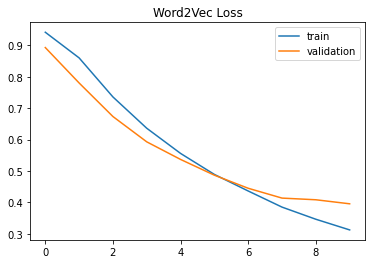

In [54]:
# plot the loss
plt.title("Word2Vec Loss")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

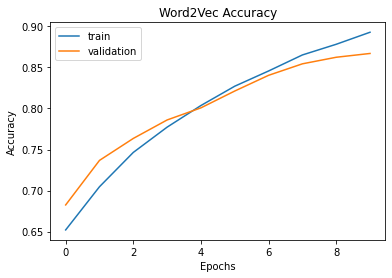

In [55]:
# plot the accuracy
plt.title("Word2Vec Accuracy")
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

Glove Dataset

In [56]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = glove_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [57]:
# define the model
model2 = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model2.add(e)
model2.add(LSTM(100, dropout=0.2))
model2.add(Flatten())
model2.add(Dense(6, activation='softmax'))


# compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          39264300  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 39,425,306
Trainable params: 161,006
Non-trainable params: 39,264,300
_________________________________________________________________


In [58]:
# fit the model
history2 = model2.fit(X_train_padded_docs, Y_train, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
1000/1000 [==============================] - 11s 10ms/step - loss: 0.9323 - accuracy: 0.6509 - val_loss: 0.8904 - val_accuracy: 0.6668
Epoch 2/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.8231 - accuracy: 0.7057 - val_loss: 0.7437 - val_accuracy: 0.7264
Epoch 3/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6616 - accuracy: 0.7672 - val_loss: 0.6041 - val_accuracy: 0.7854
Epoch 4/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5465 - accuracy: 0.8112 - val_loss: 0.5107 - val_accuracy: 0.8195
Epoch 5/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4596 - accuracy: 0.8402 - val_loss: 0.4696 - val_accuracy: 0.8397
Epoch 6/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3918 - accuracy: 0.8644 - val_loss: 0.4236 - val_accuracy: 0.8536
Epoch 7/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3372 - accuracy: 0.8837 - val_loss: 0.4052 - val_accurac

In [59]:
# evaluate the model2 on the test set
accr2 = model2.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr2[0], accr2[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.3661 - accuracy: 0.8886
Test Set: 
 Loss: 0.366
 Accuracy: 0.889


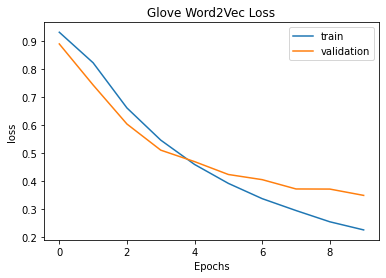

In [60]:
# plot the loss
plt.title("Glove Word2Vec Loss")
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

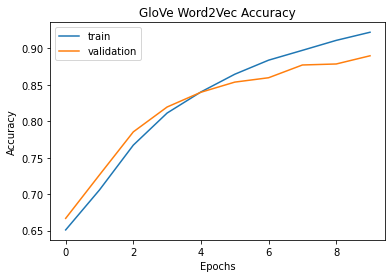

In [61]:
# plot the accuracy
plt.title("GloVe Word2Vec Accuracy")
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

Using Glove Embeddings

In [62]:
# define the model
model3 = Sequential()
model3.add(Embedding(vocab_size, 300, input_length=max_length))
model3.add(LSTM(100, dropout=0.4))
model3.add(Flatten())
model3.add(Dense(6, activation='softmax'))

# compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 300)          39264300  
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 39,425,306
Trainable params: 39,425,306
Non-trainable params: 0
_________________________________________________________________


In [63]:
# train the model
history3 = model3.fit(X_train_padded_docs, Y_train, validation_split=0.2, epochs=10, verbose=1)

Epoch 1/10
1000/1000 [==============================] - 22s 20ms/step - loss: 0.8813 - accuracy: 0.6836 - val_loss: 0.6646 - val_accuracy: 0.7925
Epoch 2/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.4889 - accuracy: 0.8525 - val_loss: 0.4538 - val_accuracy: 0.8604
Epoch 3/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.2808 - accuracy: 0.9129 - val_loss: 0.3881 - val_accuracy: 0.8857
Epoch 4/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.1822 - accuracy: 0.9411 - val_loss: 0.3820 - val_accuracy: 0.8988
Epoch 5/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.1224 - accuracy: 0.9605 - val_loss: 0.3662 - val_accuracy: 0.9094
Epoch 6/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0813 - accuracy: 0.9731 - val_loss: 0.3683 - val_accuracy: 0.9122
Epoch 7/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0577 - accuracy: 0.9806 - val_loss: 0.3763 -

In [64]:
# save learned word embeddings
own_embeddings = model3.get_layer('embedding_1').get_weights()[0]

custom_w2v = {}

for word, index in t.word_index.items():
    custom_w2v[word] = own_embeddings[index]
    
import pickle    
# save to file
with open("own_embeddings.pkl", "wb") as handle:
    pickle.dump(custom_w2v, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [65]:
# load own_embeddings
#with open("own_embeddings.pkl", "rb") as handle:
 #   own_embeddings = pickle.load(handle)

In [66]:
# evaluate the model
accr3 = model3.evaluate(X_test_padded_docs, Y_test)

print("Test Set:\n  Loss: {:0.3f}\n   Accuracy: {:0.3f}".format(accr3[0], accr3[1]))

313/313 [==============================] - 2s 5ms/step - loss: 0.4549 - accuracy: 0.9178
Test Set:
  Loss: 0.455
   Accuracy: 0.918


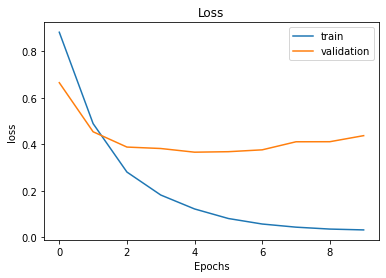

In [67]:
# plot the loss
plt.title("Loss")
plt.plot(history3.history['loss'], label='train')
plt.plot(history3.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

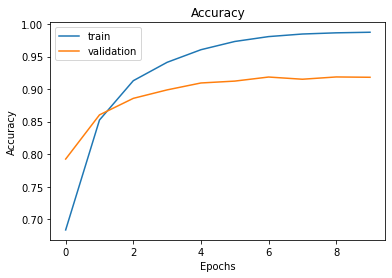

In [68]:
# plot the accuracy
plt.title("Accuracy")
plt.plot(history3.history['accuracy'], label='train')
plt.plot(history3.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [69]:
# create a dataframe to store results
res_data = {
    "Technique": ['Word2Vec', 'GloVe', 'Training data Embeddings'],
    "test accuracy": [accr[1], accr2[1], accr3[1]]
}
result = pd.DataFrame(res_data)
result

,Technique,test accuracy
0,Word2Vec,0.8697
1,GloVe,0.8886
2,Training data Embeddings,0.9178


Using CNN w Embeddings

In [70]:
emails_df2.dtypes

raw_text    object
outcome      int64
dtype: object

In [71]:
samples = []
labels = []
for index, row in emails_df2.iterrows():
    samples.append(row['raw_text'])
    labels.append(row['outcome'])

                

In [72]:
len(samples)

50000

In [73]:
#Limiting the samples to 30,000 because thats as much colab can handle
#samples = samples[:30000]
#labels = labels[:30000]

In [74]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

In [75]:
X_train

39953    ['aerials larry unfortunately there does not a...
21129    ['india trading bill upon ricks request i have...
39706    ['mw dec cap for emergency exempt for edrp mar...
13602    ['fwd media designed fair ballot to mbrown ect...
46904    ['japanese labor law memorandum twanda please ...
                               ...                        
36073     ['minutes please see attached thanks donna doc']
10781    [' there is not enough data on it to make an e...
10795    ['game tonight i dont know the ymcas policy on...
31299    ['old shipper reports sheila please add relian...
23356    ['lite bytz rsvp this weeks lite bytz presenta...
Name: raw_text, Length: 40000, dtype: object

In [76]:
#Our layer will look at the top 20,000 words, and will truncate or pad sequences to be  200 tokens long.
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)


In [77]:
path_to_glove_file = GLOVE_DATASET_PATH = 'glove.6B.300d.txt'
embeddings_index = {}
with open(path_to_glove_file,encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [78]:
#Here's a dict mapping words to their indices:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [79]:
#prepare a corresponding embedding matrix that we can use in Keras

num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 17790 words (2210 misses)


In [80]:
import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


In [81]:
class_names = ['LEGAL', 'COMMUICATIONS', 'SECURITY_SPAM_ALERTS', 'SUPPORT', 'ENERGY_DESK', 'SALES_DEPARTMENT']


In [82]:
#A simple 1D convnet with global max pooling and a classifier at the end.

from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 300)         6000600   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                         

In [83]:
len(X_train)

40000

In [84]:
#convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

x_train = vectorizer(train_samples)
x_val = vectorizer(val_samples)

y_train = np.array(train_labels)
y_val = np.array(val_labels)


In [100]:
tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.0,
    nesterov=False,
    name='SGD',
)

In [101]:
#We use categorical crossentropy as our loss since we're doing softmax classification. Moreover, we use sparse_categorical_crossentropy since our labels are integers
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="SGD", metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))


Epoch 1/20
313/313 [==============================] - 4s 10ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.7407 - val_acc: 0.9262
Epoch 2/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.7425 - val_acc: 0.9262
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.7477 - val_acc: 0.9259
Epoch 4/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 0.7515 - val_acc: 0.9260
Epoch 5/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0013 - acc: 0.9996 - val_loss: 0.7505 - val_acc: 0.9263
Epoch 6/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.7514 - val_acc: 0.9263
Epoch 7/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0015 - acc: 0.9995 - val_loss: 0.7556 - val_acc: 0.9263
Epoch 8/20
313/313 [==============================] - 3s 10ms/step - 

In [102]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["My monitor stopped responding and I need to get this spreadsheet finished as soon as possible. Please help me!"]]
)

print('Forward request to: ' + class_names[np.argmax(probabilities[0])])


Forward request to: SUPPORT


Visualization

In [87]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [88]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [103]:
y_predict=model.predict(x_val)
y_predict2= np.argmax(y_predict, axis=1)
y_true=y_val

In [104]:
lookup = {'LEGAL','COMMUICATIONS','SECURITY', 'SUPPORT', 'ENERGY', 'SALES'}

In [105]:
cm = confusion_matrix(y_true=y_true, y_pred=y_predict2)

Confusion matrix, without normalization
[[ 116   21    0   33    1    1]
 [   5 2385    2  258    2   23]
 [   2    4  123   20    2    0]
 [  15  190    7 6120    7   48]
 [   0    2    2    9  117    2]
 [   2   16    3   63    0  399]]


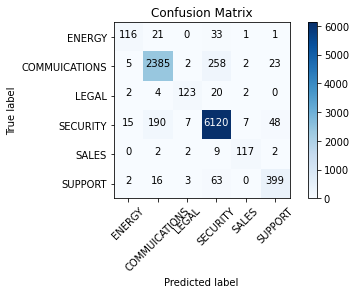

In [106]:
plot_confusion_matrix(cm=cm, classes=lookup, title='Confusion Matrix')

In [93]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [107]:
np.mean(recall)

0.8299982518489347

In [108]:
np.mean(precision)

0.8776941994995465

Zero Shot Transformer Comparison

In [97]:
pip install flair

     |████████████████████████████████| 322 kB 5.3 MB/s 
     |████████████████████████████████| 788 kB 74.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.8 MB 61.6 MB/s 
     |████████████████████████████████| 67 kB 6.7 MB/s 
     |████████████████████████████████| 1.2 MB 58.6 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 46 kB 4.9 MB/s 
     |████████████████████████████████| 48 kB 6.3 MB/s 
     |████████████████████████████████| 19.7 MB 35.6 MB/s 
     |████████████████████████████████| 981 kB 65.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 596 kB 70.8 MB/s 
     |████████████████████████████████| 6.5 MB 59.1 MB/s 
     |████████████████████████████████| 895 kB 71.2 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9

In [110]:
from flair.models import TARSClassifier
from flair.data import Sentence

# 1. Load our pre-trained TARS model for English
tars = TARSClassifier.load('tars-base')

# 2. Prepare a test sentence
sentence = Sentence("Hello, my computer isnt working, i need help")
# 3. Define some classes that you want to predict using descriptive names
classes = ["LEGAL", "COMMUICATIONS", "SECURITY", "Support", "ENERGY", "SALES"]

#4. Predict for these classes
tars.predict_zero_shot(sentence, classes)

# Print sentence with predicted labels
print(sentence)

2022-03-25 07:02:42,408 loading file /root/.flair/models/tars-base-v8.pt
Sentence: "Hello , my computer isnt working , i need help"   [− Tokens: 10  − Sentence-Labels: {'LEGAL-COMMUICATIONS-SECURITY-Support-ENERGY-SALES': [Support (0.5494)]}]
